Importuojami visi reikiami paketai, aprašomas kintamasis $t$ ir funkcija $x(t)$:

In [438]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
init_printing(use_unicode=True)
t = symbols('t')
x = Function('x')

## Medžiaga

* [Štai čia](https://stackoverflow.com/questions/39619128/) yra šaltinis, kuriuo remiuosi programuodamas krypčių laukų braižyklę.
* [Štai čia](https://www.math.tamu.edu/~efendiev/math442_spring04/matlabode.pdf) yra gera teorinė medžiaga, aiškinanti, kaip reikia braižyti krypčių laukus.
* Šios medžiagos 7 psl. aiškinama komandų `quiver` ir `meshgrid` prasmė
* Visos funkcijos testuojamos remiantis laboratorinių darbų [aprašymu](https://klevas.mif.vu.lt/~olgas/DL/LabDarbai.pdf)

## Programos struktūra

### Pagalbiniai metodai

* Iliustracija, parodanti, kaip konstruojamas tinklelis:

In [118]:
X, Y = np.arange(0, 1, 0.25), np.arange(0,1,0.2)
print(*np.meshgrid(X, Y), sep='\n')

[[0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]
 [0.   0.25 0.5  0.75]]
[[0.  0.  0.  0. ]
 [0.2 0.2 0.2 0.2]
 [0.4 0.4 0.4 0.4]
 [0.6 0.6 0.6 0.6]
 [0.8 0.8 0.8 0.8]]


* `sympy` išraiškų vektorizavimas (dvimatis), kurį naudosime krypčių laukams braižyti:

In [102]:
expr = x(t)*cos(t) - cos(t)
X, Y = np.meshgrid(np.arange(0, 1, 0.25), np.arange(0, 1, 0.25))
func = lambdify([t, x(t)], expr)
dy = func(X, Y)
print('Testing, if lamdified "x(t)*cos(t) - cos(t)" is the same as Y * np.cos(X) - np.cos(X):', 
      np.all(dy == Y * np.cos(X) - np.cos(X)))
print('Expected output:\n', Y * np.cos(X) - np.cos(X))

Testing, if lamdified "x(t)*cos(t) - cos(t)" is the same as Y * np.cos(X): True
Expected output:
 [[-1.         -0.96891242 -0.87758256 -0.73168887]
 [-0.75       -0.72668432 -0.65818692 -0.54876665]
 [-0.5        -0.48445621 -0.43879128 -0.36584443]
 [-0.25       -0.24222811 -0.21939564 -0.18292222]]


* `sympy` išraiškų vektorizavimas (vienmatis), kurį naudosime kreivėms braižyti:

[0.04978707 0.06392786 0.082085   0.10539922 0.13533528 0.17377394
 0.22313016 0.2865048  0.36787944 0.47236655 0.60653066 0.77880078
 1.         1.28402542 1.64872127 2.11700002]


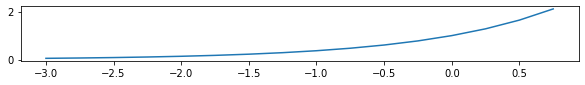

In [129]:
X = np.arange(-3, 1, 0.25)
func = lambdify(t, exp(t), 'numpy')
plt.figure(figsize=(10,1))
plt.plot(X,func(X))
print(func(X))

* Šis būdas veikia ne taip, kaip reikėtų, kai išraiška neturi kintamųjų:

In [130]:
func = lambdify(t, 1, 'numpy')
print(func(X))
#plt.plot(X,func(X)) komanda negalima

1


Ši problema buvo [svarstoma ir kitur](https://github.com/sympy/sympy/issues/5642). Sprendimas: naudoti [`np.vectorize`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html). Panaudojus šį sprendimą, galima išvengti klaidų, kurios atsiranda tada, kai norime pavaizduoti DL Koši sprendinį, kuris yra pastovus.

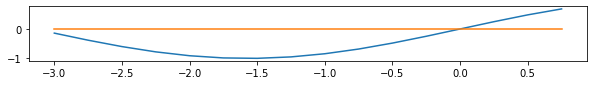

In [132]:
func1 = np.vectorize(lambdify(t, sin(t), 'numpy'))
func2 = np.vectorize(lambdify(t, 0, 'numpy'))
plt.figure(figsize=(10,1))
plt.plot(X, func1(X))
plt.plot(X, func2(X))

### Pagrindiniai metodai

* Sprendimo išplėtimas Koši uždaviniui:

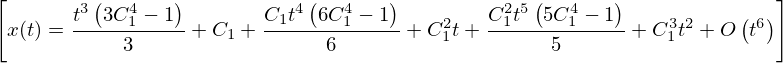

In [319]:
def spręsk(expr, ics=None):
    eq = x(t).diff(t) - expr
    solution = dsolve(eq) # like x(t)=...
    if solution.has(O):
        print('Warning: there is no explicit solution')
        return solution
    if ics is None:
        return solution
    else:
        constants = solve(solution.rhs.subs(t, ics[0]) - ics[1], symbols('C1'))
        if len(constants)==1:
            #print('value of C1:',constants[0])
            return solution.subs({'C1':constants[0]})
        elif len(constants)==0:
            print(f'Warning: x({ics[0]})={ics[1]} is not defined')
        else:
            raise NotImplementedError(f'More than one solution for x({ics[0]})=ics[1]')
  
[spręsk(x(t)**2-t**2)]
#[spręsk(1-x(t)*tan(t)).rhs]
#[spręsk(x(t)*cos(t)), spręsk(x(t)*cos(t),(0,1)), spręsk(x(t)*cos(t),(1,0)), spręsk(x(t)*cos(t),(1,1))]
#[spręsk(2*x(t)/(1+t) + (1+t)**3, ics=(-1,1))]

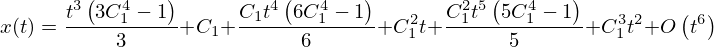

In [231]:
from sympy import dsolve
t = symbols('t')
x = Function('x')
dsolve(x(t).diff(t) - x(t)**2 + t**2)


* Funkcija, su kuria galima automatiškai braižyti formos $x'(t)=f(t)$ lygties krypčių laukus:

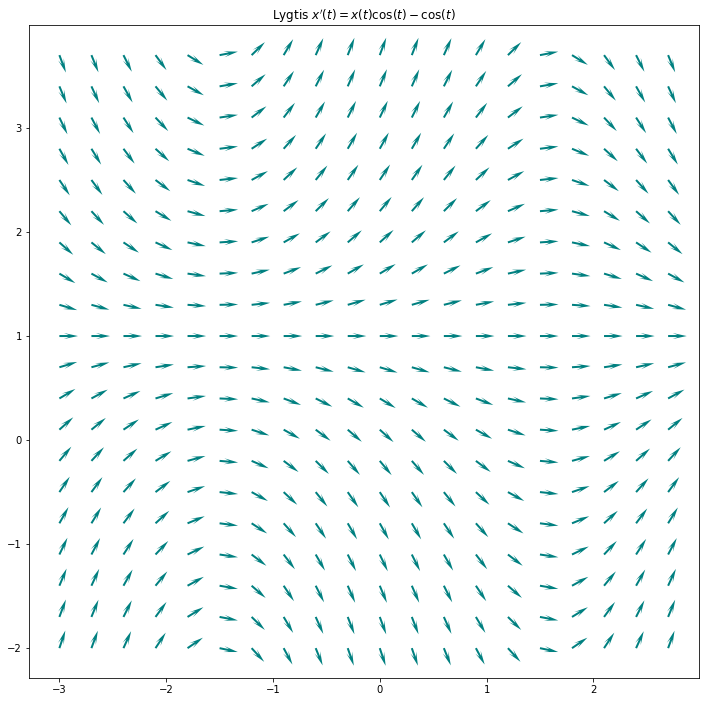

In [426]:
def braižyk(expr, fig=None, ax=None, xlim=[-3, 3], ylim=[-2, 4], size=20):
    if fig is None:
        fig = plt.figure(figsize=(12, 12))
    if ax is None:
        ax = fig.gca()
        
    xstep=np.ptp(xlim)/size
    ystep=np.ptp(ylim)/size
    X, Y = np.meshgrid(np.arange(*xlim, xstep), np.arange(*ylim, ystep))
    func = lambdify([t, x(t)], expr)
    dy = func(X, Y)
    dx = np.ones(dy.shape)*ystep/xstep
    h = np.hypot(dx, dy)
    dx, dy = dx/h, dy/h # using normalized directions by default
    #n = -1
    #color_array = np.sqrt(((dx-n)/2)**2 + ((dy-n)/2)**2) # color_array is param of ax.quiver
    ax.quiver(X, Y, dx, dy, color='Teal', headlength=7) # color='Teal'
    ax.set_title("Lygtis $x'(t) = "+latex(expr)+"$")
    return fig, ax
braižyk(x(t)*cos(t) - cos(t))
plt.show()

* Funkcija, su kuria galima automatiškai braižyti formos $x'(t)=f(t)$ lygties sprendinį, 
einantį per duotą tašką $(t_0, x_0)$:

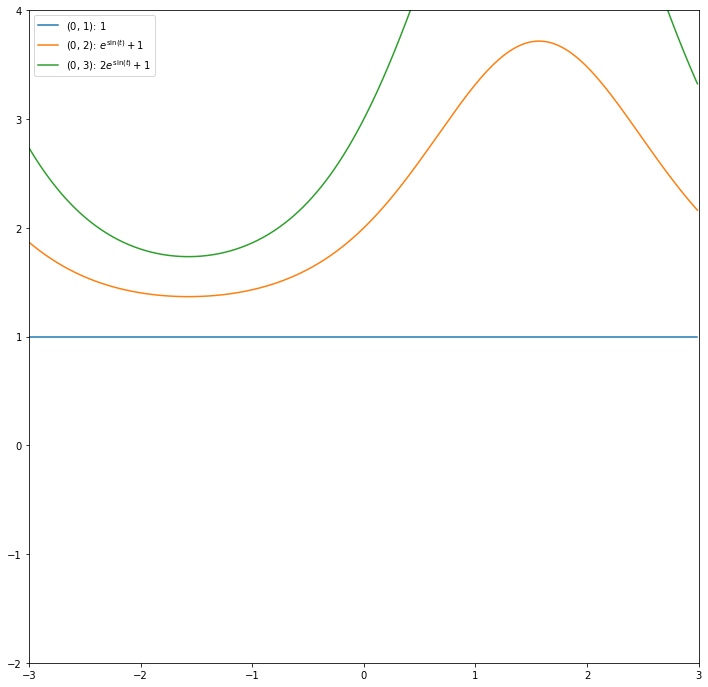

In [458]:
def brėžk_kreivę(expr, ics, fig=None, ax=None, xlim=[-3, 3], ylim=[-2, 4], step=0.01):
    if fig is None:
        fig = plt.figure(figsize=(12, 12))
    if ax is None:
        ax = fig.gca()
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    sol = spręsk(expr, ics)
    if sol is not None:
        func = np.vectorize(lambdify(t, sol.rhs, 'numpy'))
        X = np.arange(*xlim, step)
        try:
            ax.plot(X, func(X), label=str(ics)+': $'+latex(sol.rhs)+'$')
        except NameError:
            print(sol.rhs)
            print(f'np.arange({xlim[0]},{xlim[1]},{step})')
            1/0
    return fig, ax
    
fig, ax = brėžk_kreivę(x(t)*cos(t) - cos(t), (0,1), xlim=[-3, 3], ylim=[-2, 4])
fig, ax = brėžk_kreivę(x(t)*cos(t) - cos(t), (0,2), fig, ax, xlim=[-3, 3], ylim=[-2, 4])
fig, ax = brėžk_kreivę(x(t)*cos(t) - cos(t), (0,3), fig, ax, xlim=[-3, 3], ylim=[-2, 4])
plt.legend()
plt.show()

* Jei lygtis $x'(t)=f(t)$ neturi išreikštinio sprendinio, kreivė brėžiama remiantis skaitiniais metodais. Šiuo atveju yra konstruojama seka taškų, kur kiekvienas taškas yra pažingsniui gaunamas iš ankstesnio paslinkus jį tam tikra nuo ankstesnio taško priklausančia kryptimi. Iš pradžių yra pasirenkamas pradinis taškas $(t_0, x_0)$, sudaromos dvi kreivės einančios palei kryptinį lauką ir prieš kryptinį lauką ir sujungiamos tarpusavyje. Gauta nauja kreivė gali būti netiksli.

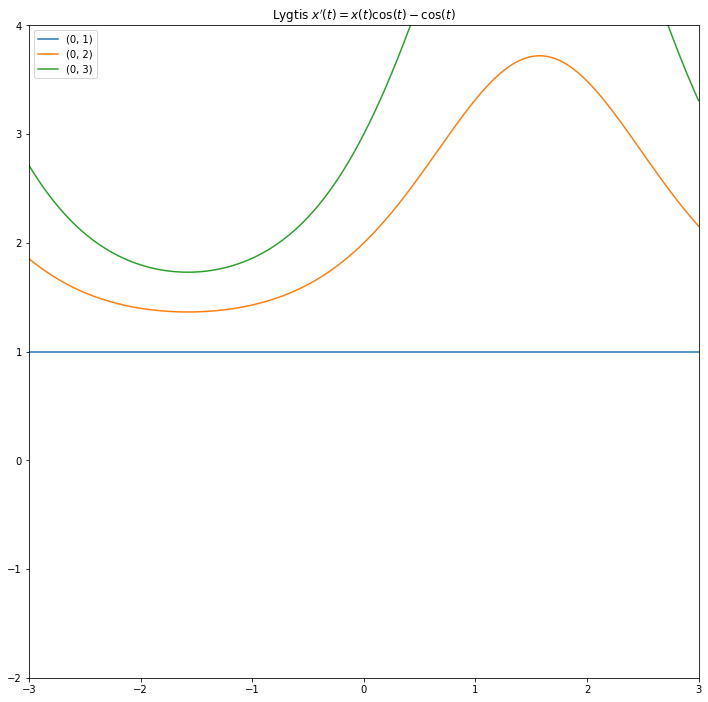

In [451]:
def kelias(expr, X, Y, xstep, ystep, direction, step):
    curve = [(X,Y)]
    for i in range(1000):
        func = lambdify([t, x(t)], expr, 'numpy')
        dy = func(*np.array([X, Y]).astype(float))
        dx = 1 #ystep/xstep
        try:
            h = np.hypot(dx, dy)
        except AttributeError:
            print('KLAIDA')
            print(np)
            print(dx)
            print(dy)
            exit
        dx, dy = direction*step * dx/h, direction*step * dy/h # using normalized directions by default
        X, Y = X+dx, Y+dy
        curve.append((X, Y))
    return curve

def brėžk(expr, ics, fig=None, ax=None, xlim=[-3, 3], ylim=[-2, 4], step=0.01):
    if fig is None:
        fig = plt.figure(figsize=(12, 12))
    if ax is None:
        ax = fig.gca()  
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    xstep=np.ptp(xlim)/size
    ystep=np.ptp(ylim)/size
    
    curve1 = kelias(expr, *ics, xstep, ystep, direction=1, step=step)
    curve2 = kelias(expr, *ics, xstep, ystep, direction=-1, step=step)
    curve = curve2[::-1]+curve1
    ax.plot(*zip(*curve), label=str(ics))
    #ax.scatter(*zip(*curve), label=str(ics),s=1)
    ax.set_title("Lygtis $x'(t) = "+latex(expr)+"$")
    return fig, ax

fig, ax = brėžk(x(t)*cos(t) - cos(t), (0,1), xlim=[-3, 3], ylim=[-2, 4])
fig, ax = brėžk(x(t)*cos(t) - cos(t), (0,2), fig, ax, xlim=[-3, 3], ylim=[-2, 4])
fig, ax = brėžk(x(t)*cos(t) - cos(t), (0,3), fig, ax, xlim=[-3, 3], ylim=[-2, 4])
plt.legend()
plt.show()

* Būdas, kaip patikrinti, ar diferencialinė lygtis turi išreikštinį sprendinį, nėra akivaizdus. 
Norint jį rasti, [uždaviau klausimą](https://stackoverflow.com/questions/60698270/how-to-check-if-sympy-dsolve-can-solve-differential-equation-in-explicit-form) per StackOverflow. Sužinojau, kad tai įmanoma atlikti naudojant komandą `sol.has(O)`. Be to atsiskleidė `sympy` paketo trūkumas: norint patikrinti, ar sprendinys neišreikštinis, pirmiausia gaunamas sprendinio skleidinys ir tada tikrinama, ar jis begalinis. Sprendinio skleidimas yra bereikalingas ir užima daug laiko.

## Darbo su lygtimis pavyzdys:

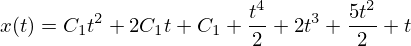

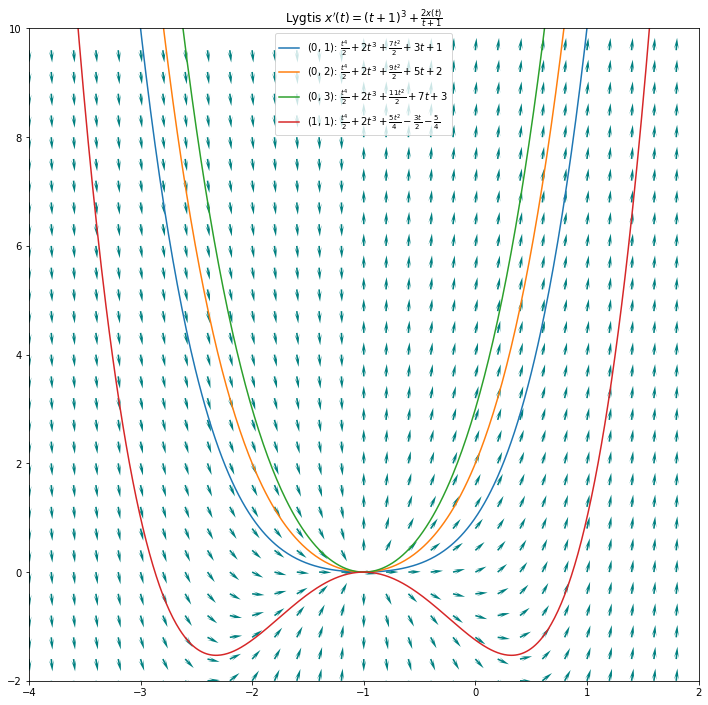

In [381]:
# xlim, ylim - keičia koordinačių ribas
# size - reguliuoja brėžiamų krypčių tankumą
# step - reguliuoja kreivės taškų tankumą

def paruošk(expr, xlim=[-7, 7], ylim=[-2, 10], lines=[], size=30):
    solution = spręsk(expr)
    border = {'xlim':xlim, 'ylim':ylim} 
    fig, ax = braižyk(expr, **border, size=size)
    if solution.has(O):
        for line in lines: 
            brėžk(expr, line, fig, ax, **border)
    else:
        display(solution)
        for line in lines: 
            brėžk_kreivę(expr, line, fig, ax, **border)
            #brėžk(expr, line, fig, ax, **border)
    plt.legend()
    plt.show()

paruošk(expr = 2*x(t)/(1+t) + (1+t)**3, 
        xlim=[-4,2], ylim=[-2,10], 
        lines = [(0,1), (0,2), (0,3), (1,1)])

## Testinių uždavinių rezultatai

Rasti bendrąjį DL sprendinį, nubraižyti DL krypčių lauką ir atskirųjų sprendinių kreives.

|Nr.|Lygtis|Sprendinys|Testo rezultatai|
|--|--------------------------------|:------------------------------------:|----|
|1.|$$x'=x\text{tg}(t)+\frac{1}{\cos(t)}$$|sprendinys neišreikštinis, kryptys susiduria kaktomuša|OK|
|2.|$$x' = \frac{2x}{1 + t} + (t + 1)^{3}$$|$$x{\left(t \right)} = C_{1} t^{2} + 2 C_{1} t + C_{1} + \frac{t^{4}}{2} + 2 t^{3} + \frac{5 t^{2}}{2} + t$$|OK|
|3.|$$x' = x\cos(t) - \cos(t)$$|$$x{\left(t \right)} = C_{1} e^{\sin{\left(t \right)}} + 1$$|OK|
|4.|$$x' = 1 − x \text{tg}(t)$$| $$\tiny{x{\left(t \right)} = \left(C_{1} - \frac{\log{\left(\sin{\left(t \right)} - 1 \right)}}{2} + \frac{\log{\left(\sin{\left(t \right)} + 1 \right)}}{2}\right) \cos{\left(t \right)}}$$ |beveik visur neapibrėžtas sprendinys|
|5.|$$x' = 1+x\text{ctg}(t)$$ $$x(\pi/2)=0$$| $$\tiny{x{\left(t \right)} = \left(C_{1} + \frac{\log{\left(\cos{\left(t \right)} - 1 \right)}}{2} - \frac{\log{\left(\cos{\left(t \right)} + 1 \right)}}{2}\right) \sin{\left(t \right)}}$$ |beveik visur neapibrėžtas sprendinys|
|6.|$$x' = x^2-t^2$$ $$x(1)=2$$|sprendinys neišreikštinis|OK|
|7.|$$x' = \frac{x}{\text{tg}(t)}$$ $$x(\frac{\pi}{6})=1$$| $$x{\left(t \right)} = C_{1} \sin{\left(t \right)}$$|OK|
|8.|$$x' = \left(\frac{x}{t}\right)^2 + 6\left(\frac{x}{t}\right)+6$$ $$x(1)=1$$|$$x{\left(t \right)} = - \frac{t \left(- 2 C_{1} + 3 t\right)}{- C_{1} + t}$$|praleidžiamos asimptotės
|9.| $$x' = x^2+1$$ $$x(1)=2$$|$$x{\left(t \right)} = - \tan{\left(C_{1} - t \right)}$$|praleidžiamos asimptotės|
|10.| $$x'=\frac{x}{t}+x\sin{t}$$ $$x(2)=1$$|$$x{\left(t \right)} = C_{1} t e^{- \cos{\left(t \right)}}$$|OK|
|11.| $$x'=-x+e^{-t}$$ $$x(0)=1$$|$$x{\left(t \right)} = \left(C_{1} + t\right) e^{- t}$$|OK|
|12.| $$x'=-2tx+te^{-t^{2}}$$ $$x(0)=2$$|$$x{\left(t \right)} = \left(C_{1} + \frac{t^{2}}{2}\right) e^{- t^{2}}$$|OK|
|13.| $$x'=\frac{t}{x}+\frac{x}{t}$$ $$x(1)=1$$|$$x{\left(t \right)} = \sqrt{t^{2} \left(C_{1} + 2 \log{\left(t \right)}\right)}$$|braižoma ne apibrėžimo srityje|
|14.|$$x'=\left(\frac{x}{t}\right)^2+\frac{x}{t}+1$$ $$x(1)=1$$|$$x{\left(t \right)} = \frac{t}{\tan{\left(C_{1} - \log{\left(t \right)} \right)}}$$|praleidžiamos asimptotės, braižoma ne apibrėžimo srityje|
|15.|$$x'=\left(\frac{x}{t}\right)^2-\frac{x}{t}$$|$$x{\left(t \right)} = \frac{1}{t \left(C_{1} + \frac{1}{2 t^{2}}\right)}$$|OK|
|16.|$$x'=\frac{x}{t}+t^2$$|$$x{\left(t \right)} = t \left(C_{1} + \frac{t^{2}}{2}\right)$$|OK|
|17.|$$x'=4tx+t$$ $$x(0)=3/4$$| $$x{\left(t \right)} = \frac{C_{1} e^{2 t^{2}}}{4} - \frac{1}{4}$$| OK|
|18.|$$x'=-2tx+e^{-t^2}$$ $$x(0)=5$$|$$x{\left(t \right)} = \left(C_{1} + t\right) e^{- t^{2}}$$| OK|
|19.|$$x'= x+e^{-t}/(1+t^2)$$ $$x(0)=2$$|$$x{\left(t \right)} = \left(C_{1} + \int \frac{e^{- 2 t}}{t^{2} + 1}\, dt\right) e^{t}$$|sprendinys išreiškiamas nesuintegruojamu integralu, todėl neįmanoma nubrėžti kreivių*|
|20.|$$x'=-2x/t+1/x^2$$ $$x(3)=1$$|$$x{\left(t \right)} = \sqrt[3]{\frac{C_{1} + \frac{3 t^{7}}{7}}{t^{6}}}$$|sprendiniui priklauso kompleksinės šaknys, kurių neįmanoma nubrėžti|
|21.|$$x'(t) = x\cos(t)$$|$$x{\left(t \right)} = C_{1} e^{\sin{\left(t \right)}}$$|OK|
|22.|$$x'(t) = \cos(x^2-t^2)$$|sprendinys neišreikštinis|OK|
|23.|$$x'(t) = \cos(x^2+t^2)$$|sprendinys neišreikštinis|OK|

## Vykdytos užklausos

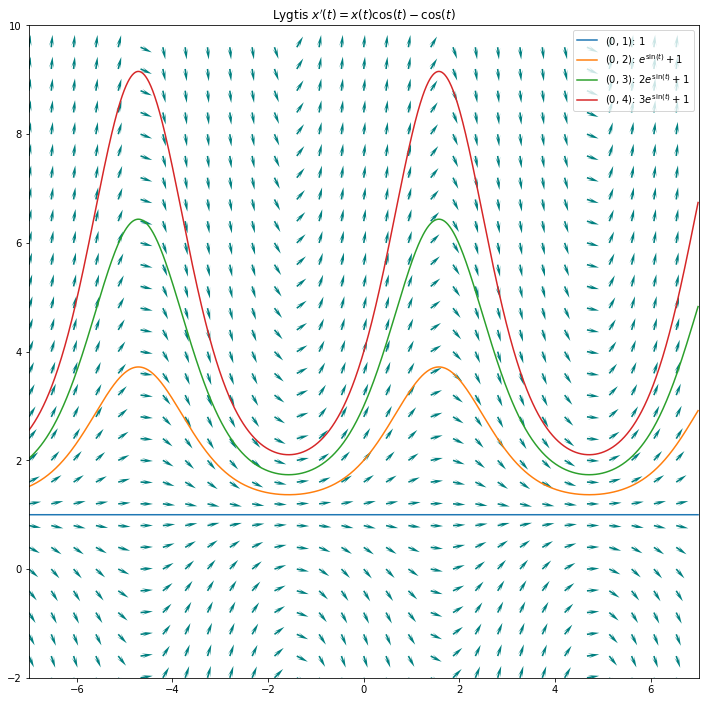

In [465]:
#CRITICAL EXAMPLES:
#paruošk(expr=1-x(t)*tan(t), xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(0,-1),(1,0),(-1,0),(pi/2,0)])
#paruošk(expr=1+x(t)/tan(t), xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(0,-1),(1,0),(-1,0),(pi/2,0)])
#paruošk(expr=x(t)**2+1, xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(1,0),(-1,0),(1,2)])
#paruošk(expr=(x(t)/t)**2 + 6*(x(t)/t)+6, xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(1,0),(-1,0),(1,1)])
#paruošk(expr=x(t)/t+t/x(t), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(1,1),(0,2)])
#paruošk(expr=(x(t)/t)**2+(x(t)/t)+1, xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(1,1/tan(1)),(exp(1),1)])
#paruošk(expr=x(t)+exp(-t)/(1+t**2), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(0, 3/4),(0, 2)])
#paruošk(expr=-2*x(t)/t+1/x(t)**2, xlim=[-5,5], ylim=[-5,5], lines=[(3,1)])


#WORKING EXAMPLES:
#paruošk(expr=x(t)*tan(x(t))+1/cos(t), xlim=[-4,4], ylim=[-4,4], lines=[(0,1),(0,-1),(1,0),(-1,0),(pi/2,0)])
#paruošk(expr=2*x(t)/(1+t) + (1+t)**3, xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(0,2),(0,3),(1,1)])
paruošk(expr=x(t)*cos(t) - cos(t), xlim=[-7,7], ylim=[-2,10], lines = [(0,1),(0,2),(0,3),(0,4)])
#paruošk(expr=x(t)**2-t**2, xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(0,-1),(1,0),(-1,0),(pi/2,0)])
#paruošk(expr=3*t**2, xlim=[-3, 3], ylim=[-3, 3], lines=[(0,1),(-1,0),(0,-1),(0,4),(1,0),(1.5,0)])
#paruošk(expr=x(t)/tan(t), xlim=[-4,2], ylim=[-2,10], lines=[(0,1),(1,0),(-1,0),(pi/6,1)])
#paruošk(expr=x(t)/t + x(t)*sin(t), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(1,1),(2,1)])
#paruošk(expr=-x(t)+exp(-t), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(1,1),(2,1)])
#paruošk(expr=-2*x(t)*t+t*exp(-t**2), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(1,1),(0,2)])
#paruošk(expr=(x(t)/t)**2-(x(t)/t), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(1,0.4),(1,1)])
#paruošk(expr=x(t)/t+t**2, xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(2,10),(1,1)])
#paruošk(expr=4*x(t)*t+t, xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(0, 3/4),(1,1)])
#paruošk(expr=-2*t*x(t)+exp(-t**2), xlim=[-5,5], ylim=[-5,5], lines=[(0,1),(1,0),(-1,0),(0, 5),(1,1)])
#paruošk(expr=x(t)*cos(t), xlim=[-5,5], ylim=[-5,5], lines=[(3,1)])
#paruošk(expr=cos(x(t)**2+t**2), xlim=[-5,5], ylim=[-2,2], lines=[(3,1)])
#paruošk(expr=cos(x(t)**2-t**2), xlim=[0,6], ylim=[0.5,2.5], lines=[(5,1)])

### Pastebėtos klaidos

sprendinys išreiškiamas nesuintegruojamu integralu, todėl neįmanoma nubrėžti kreivių*

In [461]:
rhs = (Integral(exp(-2*t)/(t**2 + 1), t) - Integral(exp(-2*t)/(t**2 + 1), (t, 0)) + 1)*exp(t)
func = np.vectorize(lambdify(t, rhs, 'numpy'))
X = np.arange(-5,5,0.01)
ax.plot(X, func(X), label=str(ics)+': $'+latex(rhs)+'$')

NameError: name 'Integral' is not defined